In [154]:
import numpy as np
import pandas as pd
import pandas.io.sql as psql
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib
import matplotlib.pyplot as plt
import openpyxl

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn import model_selection, linear_model
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use("ggplot")


In [195]:
performance_2019 = pd.read_excel('../data/2019_sales_by_month.xlsx')
performance_2019.head()

,Property Name,Property Code,Brand,#Rooms,Management Company,Registration Date,Activation Date,Last Transaction,Revenue,Profit Margin,Gross Profit,Pend Prod,Neg Inv,Low Prod Sales,Shift Rep Days,PMS Port,Column1,Month of Reporting
0,Hilton Garden Inn Times Square,NYCMW,Hilto,369.0,"Highgate Hotels, Inc.",2017-10-06,2017-10-27,2019-02-01 03:49:00,48190.59,0.72970,35164.64,76.0,119.0,NaN,a long time,35010.0,Details Use Archive,January
1,InterContinental New Orleans,MSYHA,Inter,484.0,Dimension Development Company,2018-08-17,2018-09-20,2019-02-01 05:39:00,22829.80,0.67301,15364.72,69.0,86.0,99.0,6 months,5011.0,Details Use Archive,January
2,DoubleTree Suites by Hilton Hotel Boston - Cam...,BOSSB,Doubl,308.0,Hilton Worldwide,2018-04-10,2018-06-11,2019-02-01 04:58:00,22488.70,0.69884,15715.96,36.0,165.0,NaN,6 months,35010.0,Details Use Archive,January
3,Hilton Garden Inn New Orleans Convention Center,MSYGI,Hilto,286.0,Interstate Hotels and Resorts,2018-06-27,2018-09-04,2019-02-01 05:52:00,15917.05,0.84608,13467.05,142.0,239.0,NaN,7 days,35010.0,Details Use Archive,January
4,Crowne Plaza Fredericton-Lord Beaverbrook,YFCQS,Crown,169.0,IHG - Crowne Plaza,2018-09-26,2019-02-11,2019-03-01 03:58:00,544.45,0.56147,305.69,NaN,1.0,NaN,about 21 hours,5011.0,Details Use Archive,February


In [196]:
print(performance_2019.isnull().sum())
dropping_nans = performance_2019.dropna(subset=['Property Code'])
print(dropping_nans.isnull().sum())



Property Name            1
Property Code            1
Brand                    0
#Rooms                   0
Management Company     396
Registration Date        1
Activation Date          1
Last Transaction         0
Revenue                  0
Profit Margin            0
Gross Profit             0
Pend Prod             1265
Neg Inv                682
Low Prod Sales        3498
Shift Rep Days           1
PMS Port                87
Column1                  1
Month of Reporting       1
dtype: int64
Property Name            0
Property Code            0
Brand                    0
#Rooms                   0
Management Company     395
Registration Date        0
Activation Date          0
Last Transaction         0
Revenue                  0
Profit Margin            0
Gross Profit             0
Pend Prod             1264
Neg Inv                681
Low Prod Sales        3497
Shift Rep Days           0
PMS Port                86
Column1                  0
Month of Reporting       0
dtype: int64


In [100]:
dropping_nans.sort_values('Brand')
dropping_nans.replace(to_replace='Tru B', value='Tru b', inplace=True)
dropping_nans.replace(to_replace='TRU B', value='Tru b', inplace=True)
dropping_nans.replace(to_replace='TRU b', value='Tru b', inplace=True)

brand_counts = dropping_nans['Brand'].value_counts()
print(brand_counts)
print(type(brand_counts))
unique_brands = dropping_nans['Brand'].unique()
print(unique_brands)



Hilto    1343
Hampt     852
Tru b     743
Homew     380
Crown     294
Embas     243
Home2     218
Doubl     137
Holid      64
Hotel      33
Candl      30
The S      28
Avid       25
Comfo      20
IHG A      18
La Qu      12
Stayb      12
Inter      12
Renai      11
Blueb      11
Delta       7
Best        4
Quali       3
Miram       2
Aston       1
River       1
Hammo       1
Platt       1
Name: Brand, dtype: int64
<class 'pandas.core.series.Series'>
['Hilto' 'Inter' 'Doubl' 'Crown' 'Homew' 'Embas' 'Home2' 'Hampt' 'La Qu'
 'Tru b' 'Hotel' 'The S' 'Candl' 'Holid' 'Comfo' 'Avid ' 'Stayb' 'IHG A'
 'Renai' 'Blueb' 'Delta' 'Quali' 'Best ' 'River' 'Miram' 'Platt' 'Hammo'
 'Aston']


In [101]:
#replace month strings with int
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
value = 1
for month in months:
    dropping_nans.replace(to_replace=month, value=value, inplace=True)
    value+=1



In [197]:
#drop all hotels with activation date after 2019-01-01
m1 = dropping_nans['Activation Date'] <= '2019-01-01'

#drop all hotels wtih a profit margin > 0.74 or < 0.44
m2 = dropping_nans['Profit Margin'] < 0.74
m3 = dropping_nans['Profit Margin'] > 0.44
drop_masks = dropping_nans[m1 & m2 & m3].copy()
drop_masks['Brand'].value_counts()

Hampt    626
Hilto    581
Tru b    317
Homew    235
Embas    186
Home2    157
Crown    151
Doubl     73
Tru B     72
TRU b     42
The S     15
Avid      12
La Qu     12
Inter     12
Hotel     12
Candl     12
Holid     11
Comfo     11
Delta      7
Stayb      6
Name: Brand, dtype: int64

In [118]:
#create a list of brands with count of hotels <= 10
drop_brands = []
for brand in unique_brands:
    drop_brand_count = drop_masks[drop_masks['Brand'] == brand]
    if len(drop_brand_count) <= 10:
        drop_brands.append(brand)

print(drop_brands)
#drop all brands with less than 10 hotels

m4 = ~drop_masks['Brand'].isin(drop_brands)

dropped_everything = drop_masks[m4].copy()
dropped_everything

['Stayb', 'IHG A', 'Renai', 'Blueb', 'Delta', 'Quali', 'Best ', 'River', 'Miram', 'Platt', 'Hammo', 'Aston']


,Property Name,Property Code,Brand,#Rooms,Management Company,Registration Date,Activation Date,Last Transaction,Revenue,Profit Margin,Gross Profit,Pend Prod,Neg Inv,Low Prod Sales,Shift Rep Days,PMS Port,Column1,Month of Reporting
0,Hilton Garden Inn Times Square,NYCMW,Hilto,369.0,"Highgate Hotels, Inc.",2017-10-06,2017-10-27,2019-02-01 03:49:00,48190.59,0.72970,35164.64,76.0,119.0,NaN,a long time,35010.0,Details Use Archive,1
1,InterContinental New Orleans,MSYHA,Inter,484.0,Dimension Development Company,2018-08-17,2018-09-20,2019-02-01 05:39:00,22829.80,0.67301,15364.72,69.0,86.0,99.0,6 months,5011.0,Details Use Archive,1
2,DoubleTree Suites by Hilton Hotel Boston - Cam...,BOSSB,Doubl,308.0,Hilton Worldwide,2018-04-10,2018-06-11,2019-02-01 04:58:00,22488.70,0.69884,15715.96,36.0,165.0,NaN,6 months,35010.0,Details Use Archive,1
5,Crowne Plaza Lansing West,LANCP,Crown,212.0,IHG - Crowne Plaza,2018-10-26,2018-10-26,2019-04-29 23:34:00,611.00,0.60129,367.39,NaN,1.0,NaN,1 day,5012.0,Details Use Archive,4
6,Homewood Suites Savannah Historic District,SAVRB,Homew,162.0,"North Point Hospitality Group, Inc.",2018-03-06,2018-04-10,2019-02-01 04:02:00,14439.60,0.63231,9130.27,977.0,17.0,NaN,10 months,35010.0,Details Use Archive,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4477,Hampton Inn Magnolia,AGOSN,Hampt,68.0,Shinn Enterprises,2018-03-14,2018-04-03,2020-01-01 01:08:00,835.85,0.60038,501.83,13.0,138.0,NaN,about 1 month,35010.0,Details Use Archive,12
4481,Tru by Hilton Bryan College Station,CLLCS,Tru b,98.0,"Integral Hospitality Solutions, LLC",2018-08-07,2018-08-27,2019-12-31 23:59:59,809.84,0.67184,544.08,46.0,94.0,NaN,4 days,35010.0,Details Use Archive,12
4487,Comfort Suites Downtown Orlando,FL094,Comfo,122.0,ONIX Hospitality,2017-06-05,2017-07-13,2019-12-28 22:04:00,762.75,0.58116,443.28,NaN,38.0,NaN,8 months,NaN,Details Use Archive,12
4498,Hampton Inn Greensboro-East,GSOEA,Hampt,78.0,We Care Hotels,2018-09-04,2018-09-29,2020-01-01 02:24:00,614.38,0.54211,333.06,3.0,NaN,NaN,3 months,35010.0,Details Use Archive,12


In [199]:
#create SPOR column for the year by month and add to DF
SPOR = [dropped_everything['Revenue']/(dropped_everything['#Rooms']*30.62*0.68)]
SPOR_df = pd.DataFrame(SPOR).transpose()

dropped_everything['SPOR'] = SPOR_df
test_hotels = dropped_everything.copy()
test_hotels['Brand'].value_counts()

Hampt    626
Hilto    581
Tru b    431
Homew    235
Embas    186
Home2    157
Crown    151
Doubl     73
The S     15
La Qu     12
Hotel     12
Inter     12
Avid      12
Candl     12
Holid     11
Comfo     11
Name: Brand, dtype: int64

In [179]:
#create a revenue and profit dataframe sorted by brand, then property, then month, then # rooms
revenue_and_profit_subsets = ['Property Name', 'Property Code', 'Brand', '#Rooms', 'Revenue', 'Profit Margin', 'Month of Reporting', 'SPOR'] 
rev_and_profit_df = test_hotels[revenue_and_profit_subsets].sort_values(['Brand', 'Property Code', 'Month of Reporting', '#Rooms']).copy()
rev_and_profit_columns = ['#Rooms', 'Revenue', 'Profit Margin']



In [201]:
#Closer look at HILTON ONLY
hilton_performance_2019_subset = rev_and_profit_df.loc[rev_and_profit_df["Brand"]=='Hilto']
hilton_rev_columns = hilton_performance_2019_subset[rev_and_profit_columns].copy()

# print(hilton_hotel_counts)
hilton_hotels = hilton_performance_2019_subset['Property Name'].unique()
print(len(hilton_hotels))
print(hilton_rev_columns)

58
      #Rooms   Revenue  Profit Margin
119    106.0   2545.15        0.73726
402    106.0   2563.15        0.73005
763    106.0   2170.50        0.72976
2478   106.0   2672.27        0.71395
2878   106.0   2718.68        0.71577
...      ...       ...            ...
2249   198.0  16110.90        0.66486
2650   198.0  15531.03        0.66691
3078   198.0  16141.79        0.66728
3538   198.0  12097.30        0.67239
4017   198.0  12065.20        0.66058

[581 rows x 3 columns]


Property Name       Hilton Dallas Plano Granite Park  Hilton Denver Inverness  \
Month of Reporting                                                              
1                                            0.58014                  0.67363   
2                                            0.58644                  0.66212   
3                                            0.59173                  0.67385   
4                                            0.56978                  0.65858   
5                                            0.62701                  0.66174   
6                                            0.66095                  0.66679   
7                                            0.66661                  0.68171   
8                                            0.69673                  0.67786   
9                                            0.70511                  0.67834   
10                                           0.71364                  0.65416   
11                          

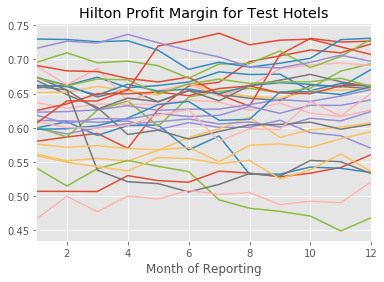

In [216]:
performance_pivot = HPS_sorted.pivot(index='Month of Reporting', columns='Property Name', values='Profit Margin')
performance_pivot_full = performance_pivot.dropna(axis=1, how='any')
print(performance_pivot_full)
performance_pivot_full.plot(legend=None, title='Hilton Profit Margin for Test Hotels')
plt.savefig('hilton_profit_margin.png')

In [202]:
# A closer look at Hampton Inn only
hampton_performance_2019_subset = rev_and_profit_df.loc[rev_and_profit_df["Brand"]=='Hampt']
hampton_rev_columns = hampton_performance_2019_subset[rev_and_profit_columns].copy()

hampton_hotels = hampton_performance_2019_subset['Property Name'].unique()
print(len(hampton_hotels))
print(hampton_rev_columns)

59
      #Rooms  Revenue  Profit Margin
238     68.0   853.44        0.59587
476     68.0  1540.89        0.60113
782     68.0  1878.07        0.61953
1100    68.0  1559.77        0.62211
1427    68.0  1802.30        0.60970
...      ...      ...            ...
3255   144.0  3689.41        0.73853
4248   144.0  2480.74        0.71558
253    137.0   535.11        0.45822
1154   137.0   729.68        0.46785
3517   137.0   531.53        0.53049

[626 rows x 3 columns]


Property Name       Hampton Inn & Suites Asheville (I-26)  \
Month of Reporting                                          
1                                                 0.61225   
2                                                 0.60341   
3                                                 0.60168   
4                                                 0.60393   
5                                                 0.62293   
6                                                 0.61476   
7                                                 0.61356   
8                                                 0.62332   
9                                                 0.63811   
10                                                0.58651   
11                                                0.59234   
12                                                0.57822   

Property Name       Hampton Inn & Suites Asheville Biltmore Area  \
Month of Reporting                                                 
1        

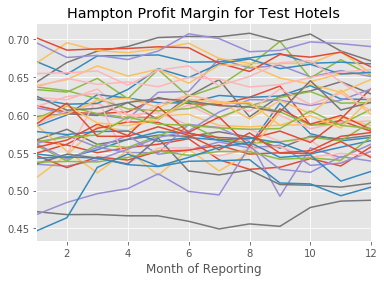

In [215]:
hampton_performance_pivot = hampton_performance_2019_subset.pivot(index='Month of Reporting', columns='Property Name', values='Profit Margin')
hampton_performance_pivot_full = hampton_performance_pivot.dropna(axis=1, how='any')
print(hampton_performance_pivot_full)
hampton_performance_pivot_full.plot(legend=None, title='Hampton Profit Margin for Test Hotels')
plt.savefig('hampton_profit_margin.png')

In [217]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, )

m0 = hilton_performance_2019_subset['Month of Reporting'] == 12
m1 = hilton_performance_2019_subset['Month of Reporting'] != 12

y_train = hilton_performance_2019_subset[m1].pop('SPOR').values
X_train = hilton_rev_columns[m1].values
y_test = hilton_performance_2019_subset[m0].pop('SPOR').values
X_test = hilton_rev_columns[m0].values


In [218]:
def my_rmse(y_true, y_pred):
    mse = ((y_true - y_pred)**2).mean()
    return mse

linear = LinearRegression()
linear.fit(X_train, y_train)

train_predicted = linear.predict(X_train)
test_predicted = linear.predict(X_test)

print('RMSE for Hilton training set ', my_rmse(y_train, train_predicted))
print('RMSE for Hilton test set ', my_rmse(y_test, test_predicted))

RMSE for Hilton training set  0.11647284683932572
RMSE for Hilton test set  0.12274394435474686


In [219]:
m2 = hampton_performance_2019_subset['Month of Reporting'] == 12
m3 = hampton_performance_2019_subset['Month of Reporting'] != 12

y_train = hampton_performance_2019_subset[m3].pop('SPOR').values
X_train = hampton_rev_columns[m3].values
y_test = hampton_performance_2019_subset[m2].pop('SPOR').values
X_test = hampton_rev_columns[m2].values

linear = LinearRegression()
linear.fit(X_train, y_train)

train_predicted = linear.predict(X_train)
test_predicted = linear.predict(X_test)

print('RMSE for Hampton training set ', my_rmse(y_train, train_predicted))
print('RMSE for Hampton test set ', my_rmse(y_test, test_predicted))

RMSE for Hampton training set  0.02910009138352963
RMSE for Hampton test set  0.05382803644606791
